In [4]:
%load_ext autoreload
%autoreload 2
import sys 
#sys.path.insert(0, '/home/bec3/Desktop/Simone_Damian/Serafini/linien_server')
print(sys.path)
print('\n'.join(sys.path))
from linien_server.autolock.robust import calculate_autolock_instructions,get_lock_position_from_autolock_instructions
from linien_server.autolock.utils import crop_spectra_to_same_view,sum_up_spectrum,get_diff_at_time_scale,get_time_scale,get_all_peaks,get_lock_region,get_target_peak
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['/home/bec3/Desktop/Simone_Damian/Serafini/linien_server', '/home/bec3/Desktop/Simone_Damian/Serafini/linien_server', '/home/bec3/Desktop/Simone_Damian/Serafini', '/home/bec3/anaconda3/envs/RP_spectroscopy/lib/python310.zip', '/home/bec3/anaconda3/envs/RP_spectroscopy/lib/python3.10', '/home/bec3/anaconda3/envs/RP_spectroscopy/lib/python3.10/lib-dynload', '', '/home/bec3/anaconda3/envs/RP_spectroscopy/lib/python3.10/site-packages']
/home/bec3/Desktop/Simone_Damian/Serafini/linien_server
/home/bec3/Desktop/Simone_Damian/Serafini/linien_server
/home/bec3/Desktop/Simone_Damian/Serafini
/home/bec3/anaconda3/envs/RP_spectroscopy/lib/python310.zip
/home/bec3/anaconda3/envs/RP_spectroscopy/lib/python3.10
/home/bec3/anaconda3/envs/RP_spectroscopy/lib/python3.10/lib-dynload

/home/bec3/anaconda3/envs/RP_spectroscopy/lib/python3.10/site-packages


In [2]:
import subprocess

# Replace with your values
remote_user = "root"
remote_ip = "192.168.1.159"
remote_path = "/root/.local/share/linien/robust_spectra.npy"
local_path = "/home/jacklook/Documents/Projects/CodeRed"
key_path = "/home/jacklook/.ssh/rp_TN"

# Use scp with SSH key
command = [
    "scp",
    "-i", key_path,
    f"{remote_user}@{remote_ip}:{remote_path}",
    local_path
]

subprocess.run(command)

# Replace with your values
remote_user = "root"
remote_ip = "192.168.1.159"
remote_path = "/root/.local/share/linien/target_idxs.npy"
local_path = "/home/jacklook/Documents/Projects/CodeRed"
key_path = "/home/jacklook/.ssh/rp_TN"

# Use scp with SSH key
command = [
    "scp",
    "-i", key_path,
    f"{remote_user}@{remote_ip}:{remote_path}",
    local_path
]

subprocess.run(command)

CompletedProcess(args=['scp', '-i', '/home/jacklook/.ssh/rp_TN', 'root@192.168.1.159:/root/.local/share/linien/target_idxs.npy', '/home/jacklook/Documents/Projects/CodeRed'], returncode=0)

In [7]:
import subprocess

# Replace with your values
remote_user = "root"
remote_ip = "10.194.33.151"
remote_port = "2223"
remote_path = "/root/.local/share/linien/robust_spectra.npy"
local_path = "/home/jacklook/Documents/Projects/CodeRed"
key_path = "/home/jacklook/.ssh/rp_TN"

# Use scp with SSH key
command = [
    "scp",
    "-i", key_path,
    "-P", remote_port,
    f"{remote_user}@{remote_ip}:{remote_path}",
    local_path
]

subprocess.run(command)



CompletedProcess(args=['scp', '-i', '/home/jacklook/.ssh/rp_TN', '-P', '2223', 'root@10.194.33.151:/root/.local/share/linien/robust_spectra.npy', '/home/jacklook/Documents/Projects/CodeRed'], returncode=0)

In [3]:

spectra = np.load('/home/jacklook/Documents/Projects/CodeRed/robust_spectra.npy')
target_idxs = np.load('/home/jacklook/Documents/Projects/CodeRed/target_idxs.npy')
N_SPECTRA = spectra.shape[0]
print(spectra[0,0])
print(f"Number of spectra: {N_SPECTRA}")

26
Number of spectra: 5


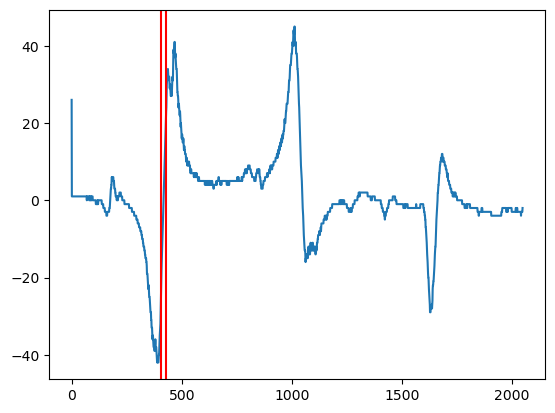

In [4]:
plt.plot(spectra[0])
x0 = target_idxs[0]
x1 = target_idxs[1]
plt.axvline(x=x0, color='r')
plt.axvline(x=x1, color='r')

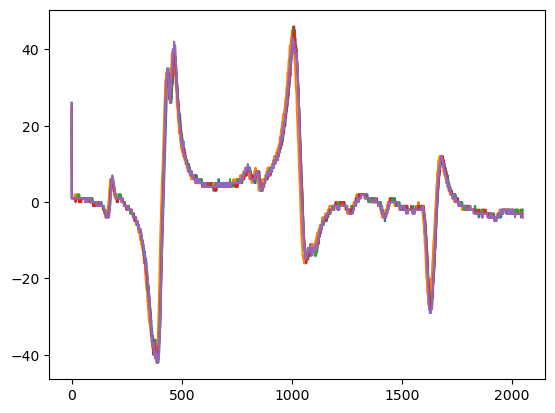

In [5]:
for i in range(N_SPECTRA):
    plt.plot(spectra[i])

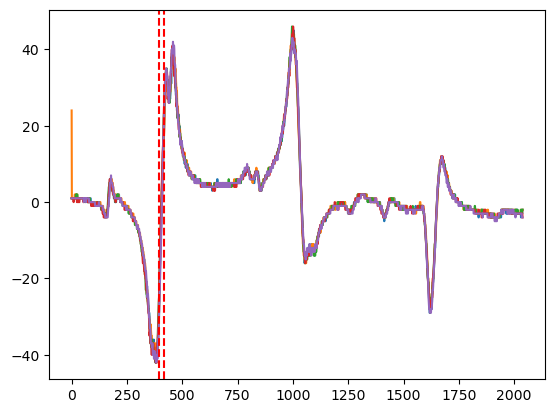

In [6]:
target_idxs = (x0,x1)
spectra_cropped, crop_left = crop_spectra_to_same_view(spectra)
for i in range(N_SPECTRA):
    plt.plot(spectra_cropped[i])

target_idxs = [idx - crop_left for idx in target_idxs]
plt.axvline(x=target_idxs[0], color='r', linestyle='--')
plt.axvline(x=target_idxs[1], color='r', linestyle='--')
time_scale = int(round(np.mean([get_time_scale(spectrum, target_idxs) for spectrum in spectra])))

shift 9
extrema are 0 21
selected region is from  406 to 428
first peak is 406 -515
peaks [(388, -835), (189, 93), (162, -66), (59, 21)]
y_scale -835


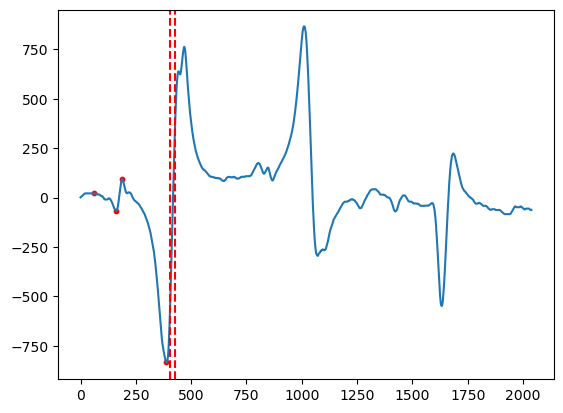

In [7]:
prepared_spectrum = get_diff_at_time_scale(sum_up_spectrum(spectra_cropped[0]), time_scale)
shift_prepared = np.argmax(correlate(prepared_spectrum, spectra_cropped[0]))-len(prepared_spectrum)
target_idxs_prepared = [idx + shift_prepared for idx in target_idxs]
print('shift', shift_prepared)
plt.plot(prepared_spectrum)
plt.axvline(x=target_idxs_prepared[0], color='r', linestyle='--')
plt.axvline(x=target_idxs_prepared[1], color='r', linestyle='--')
peaks = get_all_peaks(prepared_spectrum, target_idxs_prepared)
print('peaks', peaks)
for peak_position,peak_value in peaks:
    plt.scatter(peak_position, peak_value, color='red',s=10)
y_scale = peaks[0][1]
print('y_scale', y_scale)

[(231, 1038), (242, 1038), (231, 1039), (233, 1040), (230, 1039)]


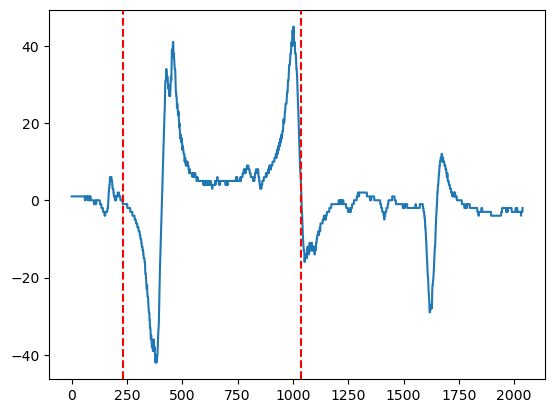

In [8]:
lock_regions = [get_lock_region(spectrum, target_idxs) for spectrum in spectra_cropped]
print(lock_regions)
plt.plot(spectra_cropped[0])
plt.axvline(x=lock_regions[0][0], color='r', linestyle='--')
plt.axvline(x=lock_regions[0][1], color='r', linestyle='--')

tolerance factor 0.95
peaks filtered [(388, -793.25), (189, 88.35), (162, -62.699999999999996)]
extrema are 0 21
selected region is from  406 to 428
target peak idx 406
final wait time 1
for tolerance 0.95 description is [(145, -62), (24, 88), (179, -793)]
lock_position 389
lock_position 383
tolerance factor 0.9
peaks filtered [(388, -751.5), (189, 83.7)]
extrema are 0 21
selected region is from  406 to 428
target peak idx 406
final wait time 1
for tolerance 0.9 description is [(170, 83), (179, -751)]
lock_position 382
lock_position 375
lock_position 380
lock_position 378
lock_position 378


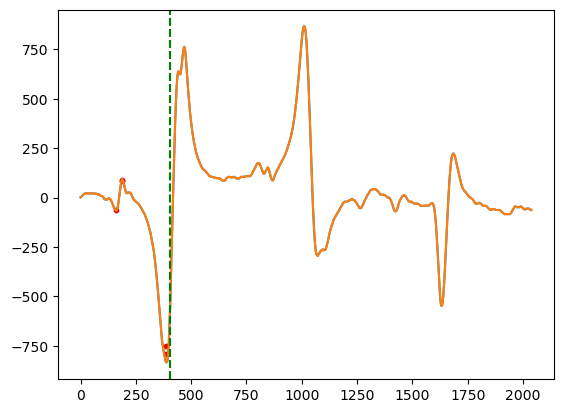

In [9]:
for tolerance_factor in [0.95,0.9,0.85,0.8,0.75,0.7]:
        #logger.debug(f"Try out tolerance {tolerance_factor}")
        peaks_filtered = [
            (peak_position, peak_height * tolerance_factor)
            for peak_position, peak_height in peaks
        ]
        # it is important to do the filtering that happens here after the previous
        # line as the previous line shrinks the values
        peaks_filtered = [
            (peak_position, peak_height)
            for peak_position, peak_height in peaks_filtered
            if abs(peak_height) > abs(y_scale * (1 - tolerance_factor))
        ]
        print('tolerance factor', tolerance_factor)
        print('peaks filtered', peaks_filtered)
        # now find out how much we have to wait in the end (because we detect the peak
        # too early because our threshold is too low)
        target_peak_described_height = peaks_filtered[0][1]
        target_peak_idx = get_target_peak(prepared_spectrum, target_idxs_prepared)
        print('target peak idx', target_peak_idx)
        plt.plot(prepared_spectrum)
        plt.axvline(x=target_peak_idx, color='g', linestyle='--')
        #plt.axvline(x=1168, color='r', linestyle='--')
        #plt.axvline(x=1468, color='r', linestyle='--')
        for peak_position, peak_height in peaks_filtered:
            plt.scatter(peak_position, peak_height, color='red', s=10)
        current_idx = target_peak_idx
        while True:
            current_idx -= 1
            if np.abs(prepared_spectrum[current_idx]) < np.abs(
                target_peak_described_height
            ):
                break
        final_wait_time = target_peak_idx - current_idx
        #logger.debug(f"final wait time is {final_wait_time} samples")
        print('final wait time', final_wait_time)
        description = []

        last_peak_position = 0
        for peak_position, peak_height in list(reversed(peaks_filtered)):
            # TODO: this .9 factor is very arbitrary.
            description.append(
                (int(0.9 * (peak_position - last_peak_position)), int(peak_height))
            )
            last_peak_position = peak_position
        print('for tolerance', tolerance_factor, 'description is', description)
        # test whether description works fine for every recorded spectrum
        does_work = True
        for spectrum, lock_region in zip(spectra, lock_regions):
            try:
                lock_position = get_lock_position_from_autolock_instructions(
                    spectrum, description, time_scale, spectra_cropped[0], final_wait_time
                )
                print('lock_position', lock_position)
                if not lock_region[0] <= lock_position <= lock_region[1]:
                    print('LockPositionNotFound')

            except:
                does_work = False

        if does_work:
            break

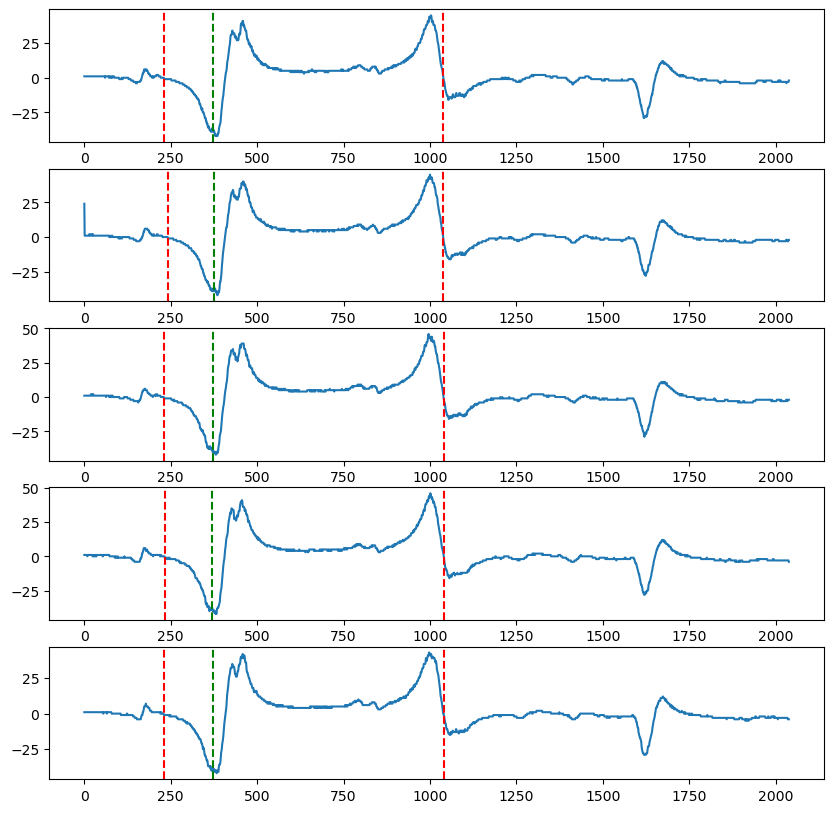

In [10]:
fig,ax = plt.subplots(ncols=1, nrows=N_SPECTRA, figsize=(10, 10))
for i in range(N_SPECTRA):
    ax[i].plot(spectra_cropped[i])
    ax[i].axvline(x=lock_regions[i][0], color='r', linestyle='--')
    ax[i].axvline(x=lock_regions[i][1], color='r', linestyle='--')
    lock_position = get_lock_position_from_autolock_instructions(
                    spectra_cropped[i], description, time_scale, spectra_cropped[0], final_wait_time
                )
    ax[i].axvline(x=lock_position, color='g', linestyle='--')

In [13]:
calculate_autolock_instructions(spectra,(1200,1500))

linien_server.autolock.robust  DEBUG    x scale is 233
linien_server.autolock.robust  DEBUG    Try out tolerance 0.95
linien_server.autolock.robust  DEBUG    final wait time is 1 samples
linien_server.autolock.robust  DEBUG    Try out tolerance 0.9
linien_server.autolock.robust  DEBUG    final wait time is 50 samples
linien_server.autolock.robust  DEBUG    Try out tolerance 0.85
linien_server.autolock.robust  DEBUG    final wait time is 56 samples
linien_server.autolock.robust  DEBUG    Try out tolerance 0.8
linien_server.autolock.robust  DEBUG    final wait time is 61 samples
linien_server.autolock.robust  DEBUG    Try out tolerance 0.75
linien_server.autolock.robust  DEBUG    final wait time is 67 samples
linien_server.autolock.robust  DEBUG    Try out tolerance 0.7


linien_server.autolock.robust  DEBUG    final wait time is 72 samples
linien_server.autolock.robust  DEBUG    Description is [(459, -35644), (432, 11748)]


extrema are 299 0
selected region is from  1013 to 1313
first peak is 1013 15769.0
extrema are 299 0
selected region is from  1013 to 1313
for tolerance 0.95 description is [(459, -48374), (432, 15943)]
extrema are 299 0
selected region is from  1013 to 1313
for tolerance 0.9 description is [(459, -45828), (432, 15104)]
extrema are 299 0
selected region is from  1013 to 1313
for tolerance 0.85 description is [(459, -43282), (432, 14265)]
extrema are 299 0
selected region is from  1013 to 1313
for tolerance 0.8 description is [(459, -40736), (432, 13426)]
extrema are 299 0
selected region is from  1013 to 1313
for tolerance 0.75 description is [(459, -38190), (432, 12587)]
extrema are 299 0
selected region is from  1013 to 1313
for tolerance 0.7 description is [(459, -35644), (432, 11748)]


([(459, -35644), (432, 11748)], 72, 233)